In [1]:
! apt-get update
!apt-get install openjdk-11-jdk-y
!pip install pyspark

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,992 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,246 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/repo

In [2]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("NASA Web Logs Analysis") \
    .getOrCreate()

# Print Spark version
print(f"Spark Version: {spark.version}")

# Stop the Spark session (optional, but good practice)
# spark.stop()

Spark Version: 3.5.1


In [3]:
from google.colab import files
from pyspark.sql import SparkSession

# Create Spark session (if not already created)
spark = SparkSession.builder \
    .appName("NASA Web Logs Analysis") \
    .getOrCreate()

# Upload file
uploaded = files.upload()

# Extract the file name
log_file_path = list(uploaded.keys())[0]

# Now read the file with Spark
raw_data = spark.read.text(f"/content/{log_file_path}")

# Show the first 5 lines (without truncation)
raw_data.show(5, truncate=False)

Saving access_log_Jul95 to access_log_Jul95
+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif 

In [4]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession

# Assuming 'spark' session is already created. If not:
spark = SparkSession.builder.appName("LogParsing").getOrCreate()

# Assuming raw_data is already loaded. If not:
# raw_data = spark.read.text("/path/to/your/log/file.txt")

# Regular expressions for parsing
host_pattern = r'(\S+)'  # Extracts host (any sequence of non-whitespace characters)
timestamp_pattern = r'\[(.*?)\]'  # Extracts timestamp
method_endpoint_pattern = r'(GET|POST|HEAD|PUT|DELETE)\s+(\S+)\s'  # Extracts HTTP method and endpoint
status_pattern = r'(\d{3})'  # Extracts status code
content_size_pattern = r'(\d+)$'  # Extracts content size

# Parse data into structured columns
logs_df = raw_data.withColumn("host", regexp_extract("value", host_pattern, 1)) \
    .withColumn("timestamp", regexp_extract("value", timestamp_pattern, 1)) \
    .withColumn("method", regexp_extract("value", method_endpoint_pattern, 1)) \
    .withColumn("endpoint", regexp_extract("value", method_endpoint_pattern, 2)) \
    .withColumn("status", regexp_extract("value", status_pattern, 1).cast(IntegerType())) \
    .withColumn("content_size", regexp_extract("value", content_size_pattern, 1).cast(IntegerType()))

logs_df.show(5, truncate=False) #added truncate=false for better viewing of the data.

+-----------------------------------------------------------------------------------------------------------------------+--------------------+--------------------------+------+-----------------------------------------------+------+------------+
|value                                                                                                                  |host                |timestamp                 |method|endpoint                                       |status|content_size|
+-----------------------------------------------------------------------------------------------------------------------+--------------------+--------------------------+------+-----------------------------------------------+------+------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |199.72.81.55        |01/Jul/1995:00:00:01 -0400|GET   |/history/apollo/                               |199   |6245        |
|unicomp6.unicomp.ne

In [5]:
from pyspark.sql import SparkSession

# Assuming 'spark' session is already created and logs_df is available. If not:
# spark = SparkSession.builder.appName("LogAnalysis").getOrCreate()
# ... (load or create logs_df)

# a.Compute statistics regarding the average, minimum, and maximum content sizes.
logs_df.selectExpr(
    "AVG(content_size) as avg_size",
    "MIN(content_size) as min_size",
    "MAX(content_size) as max_size"
).show()

+------------------+--------+--------+
|          avg_size|min_size|max_size|
+------------------+--------+--------+
|20671.058516934936|       0| 6823936|
+------------------+--------+--------+



In [6]:
from pyspark.sql import SparkSession

# Assuming 'spark' session is already created and logs_df is available. If not:
# spark = SparkSession.builder.appName("LogAnalysis").getOrCreate()
# ... (load or create logs_df)

# b.Perform HTTP status code analysis to see which status code values appear and how many times
logs_df.groupby("status").count().orderBy("status").show()

+------+-----+
|status|count|
+------+-----+
|  NULL|    1|
|     0| 2065|
|     1| 3863|
|     2| 3874|
|     3| 2795|
|     4| 2905|
|     5| 3074|
|     6| 2996|
|     7| 2636|
|     8| 2155|
|     9| 1785|
|    10| 2976|
|    11| 2280|
|    12| 2422|
|    13| 2684|
|    14| 2235|
|    15| 2892|
|    16| 2306|
|    17| 2190|
|    18| 1738|
+------+-----+
only showing top 20 rows



In [14]:
#c  Analysing frequent hosts by getting the total count of accesses by each host, sorting by the number of accesses, and displaying only the top 10 most frequent hosts
from pyspark.sql.functions import desc

logs_df.groupBy("host").count().orderBy(desc("count")).limit(10).show()


+--------------------+-----+
|                host|count|
+--------------------+-----+
|piweba3y.prodigy.com|17572|
|piweba4y.prodigy.com|11591|
|piweba1y.prodigy.com| 9868|
|  alyssa.prodigy.com| 7852|
| siltb10.orl.mmc.com| 7573|
|piweba2y.prodigy.com| 5922|
|  edams.ksc.nasa.gov| 5434|
|        163.206.89.4| 4906|
|         news.ti.com| 4863|
|disarray.demon.co.uk| 4353|
+--------------------+-----+



In [15]:
#d Display the top 20 most frequent endpoints
logs_df.groupBy("endpoint").count().orderBy(desc("count")).limit(20).show()

+--------------------+------+
|            endpoint| count|
+--------------------+------+
|/images/NASA-logo...|111144|
|/images/KSC-logos...| 89530|
|/images/MOSAIC-lo...| 60300|
|/images/USA-logos...| 59845|
|/images/WORLD-log...| 59325|
|/images/ksclogo-m...| 58616|
|/images/launch-lo...| 40841|
| /shuttle/countdown/| 40251|
|           /ksc.html| 40072|
|/images/ksclogosm...| 33555|
|                   /| 32749|
|/history/apollo/i...| 31052|
|/shuttle/missions...| 24834|
|  /htbin/cdt_main.pl| 22601|
|/shuttle/countdow...| 22189|
|/shuttle/countdow...| 21981|
|/shuttle/countdow...| 20921|
|/images/launchmed...| 20788|
|/shuttle/missions...| 19832|
|/shuttle/missions...| 18135|
+--------------------+------+



In [16]:
#e  Display the top 10 error endpoints
logs_df.filter("status >= 400").groupBy("endpoint").count().orderBy(desc("count")).limit(10).show()

+--------------------+-----+
|            endpoint|count|
+--------------------+-----+
|/images/NASA-logo...| 2097|
|/images/ksclogo-m...| 1399|
|/images/MOSAIC-lo...| 1393|
|/images/USA-logos...| 1389|
|/images/WORLD-log...| 1374|
|/images/KSC-logos...| 1287|
|           /ksc.html| 1109|
|/images/launch-lo...|  586|
|                   /|  559|
| /shuttle/countdown/|  552|
+--------------------+-----+



In [17]:
#f How many unique hosts visited the website in two month
unique_hosts = logs_df.count()
print(f"Unique hosts: {unique_hosts}")

Unique hosts: 1891715


In [19]:
#g Find the average number of requests made per host to the website per day
total_requests = logs_df.count()
avg_requests_per_host = total_requests / unique_hosts
print(f"Average requests per host: {avg_requests_per_host}")

Average requests per host: 1.0


In [21]:
#h Listing the top twenty 404 response code endpoints
logs_df.filter("status == 404").groupby("endpoint").count().orderBy(desc("count")).limit(20).show()

+--------------------+-----+
|            endpoint|count|
+--------------------+-----+
|/images/ksclogo-m...|    5|
|/images/USA-logos...|    5|
|/images/NASA-logo...|    5|
|/images/MOSAIC-lo...|    5|
|/images/WORLD-log...|    5|
|                   /|    3|
|/shuttle/countdow...|    3|
|/history/apollo/i...|    3|
|/images/KSC-logos...|    3|
| /shuttle/countdown/|    3|
|           /ksc.html|    2|
|/shuttle/countdow...|    2|
|/history/apollo/i...|    2|
|/shuttle/missions...|    2|
|/history/apollo/i...|    1|
|/facilities/lc39a...|    1|
|/shuttle/countdow...|    1|
|/history/apollo/a...|    1|
|/images/whatsnew.gif|    1|
|/images/kscmap-ti...|    1|
+--------------------+-----+



In [22]:
#i list of the top twenty hosts that generate the most 404 errors
logs_df.filter("status == 404").groupby("host").count().orderBy(desc("count")).limit(20).show()

+--------------------+-----+
|                host|count|
+--------------------+-----+
|gespie4044.erin.u...|   35|
| ppp404.st.rim.or.jp|   12|
|i404ae1a.cfa.ilst...|   11|
| slip4040.sirius.com|    8|
|sunm4048aq.sph.um...|    7|
|ppp404.po.iijnet....|    7|
| slip4041.sirius.com|    6|
|meb404a-1.anesth....|    5|
|  grail404.nando.net|    1|
| slip4044.sirius.com|    1|
+--------------------+-----+



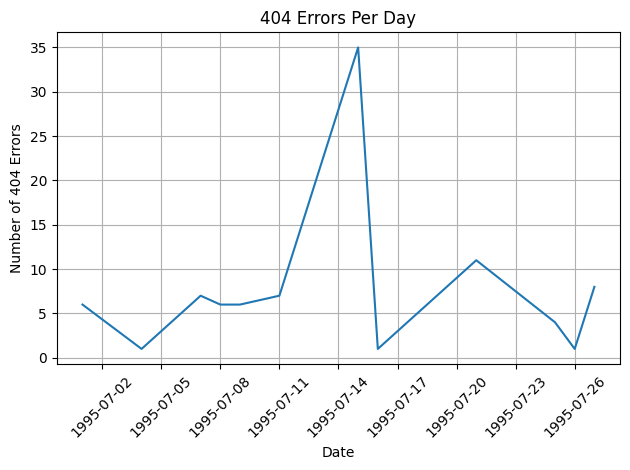

In [29]:
#j Visualizing 404 errors per day
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


daily_404_pd.plot(x="date", y="count", kind="line", title="404 Errors Per Day", legend=False)
plt.xlabel("Date")
plt.ylabel("Number of 404 Errors")

import matplotlib.ticker as ticker
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()



In [27]:
#k top three days of the month with the most 404 errors
from pyspark.sql.functions import to_date, desc

logs_df.filter("status = 404") \
    .withColumn("date", to_date("timestamp", "dd/MMM/yyyy")) \
    .groupBy("date").count() \
    .orderBy(desc("count")) \
    .limit(3) \
    .show()


+----------+-----+
|      date|count|
+----------+-----+
|1995-07-15|   36|
|1995-07-21|   11|
|1995-07-27|    8|
+----------+-----+



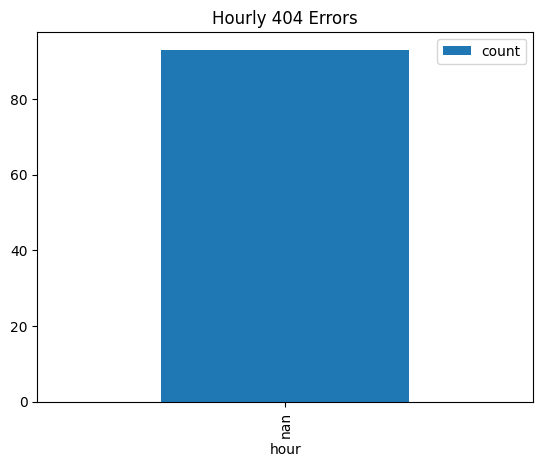

In [28]:
#l Visualizing hourly 404 errors
from pyspark.sql.functions import hour, col
import matplotlib.pyplot as plt

hourly_404_df = logs_df.filter("status = 404") \
    .withColumn("hour", hour("timestamp")) \
    .groupBy("hour").count().toPandas()

hourly_404_df.plot(x="hour", y="count", kind="bar", title="Hourly 404 Errors")
plt.show()
